In [2]:
import fastbook
fastbook.setup_book()
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
Path.BASE_PATH = path

In [5]:
print(path)

/home/mzums/.fastai/data/oxford-iiit-pet


In [6]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [7]:
(path/"images").ls()

(#7393) [Path('images/english_setter_2.jpg'),Path('images/basset_hound_50.jpg'),Path('images/american_pit_bull_terrier_107.jpg'),Path('images/american_bulldog_82.jpg'),Path('images/yorkshire_terrier_21.jpg'),Path('images/Abyssinian_33.jpg'),Path('images/leonberger_155.jpg'),Path('images/Bombay_139.jpg'),Path('images/japanese_chin_111.jpg'),Path('images/keeshond_195.jpg')...]

In [8]:
fname = (path/"images").ls()[0]

In [9]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['english_setter']

In [10]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

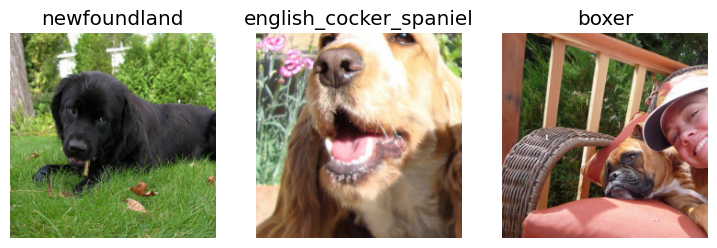

In [11]:
dls.show_batch(nrows=1, ncols=3)

In [12]:
#learn = vision_learner(dls, resnet34, metrics=error_rate)
#learn.fine_tune(2)

In [13]:
x,y = dls.one_batch()

In [14]:
y

TensorCategory([ 8, 24, 15,  7, 15, 11,  6,  4, 31, 12,  2, 11, 33,  9, 18,  7,  6, 20, 17, 16, 36,  7, 18, 36, 10,  5, 15, 33,  2, 30, 34, 32, 24, 36,  7, 33,  9, 24, 22,  7,  9,  7,  5, 24, 32, 32,
                23, 31, 16, 18, 30, 33, 25, 16,  1, 30,  2, 26, 36, 10, 29,  1, 29, 25])

In [15]:
#preds,_ = learn.get_preds(dl=[(x,y)])
#preds[0]

In [16]:
#len(preds[0]),preds[0].sum()

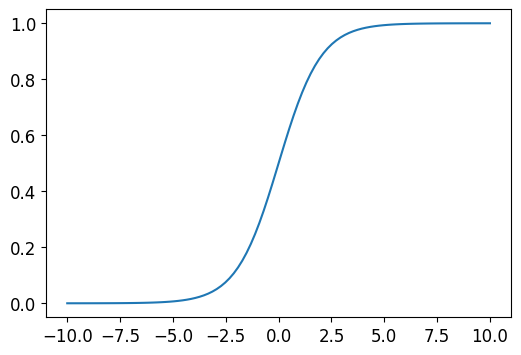

In [17]:
plot_function(torch.sigmoid, min=-10,max=10)

In [18]:
torch.random.manual_seed(42);

In [19]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [20]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [21]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [22]:
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [23]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [24]:
targ = tensor([0,1,0,1,1,0])

In [25]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [26]:
from IPython.display import HTML
import pandas as pd
# import re

df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]

t = df.style.hide(axis='index')

# html = t._repr_html_()
# 
# html = re.sub(r'<style.*?</style>', '', html)

display(t)


3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [27]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [28]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

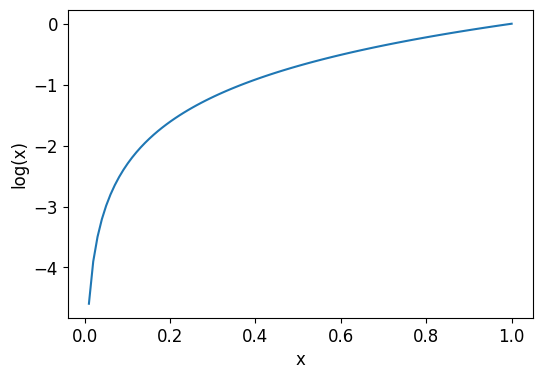

In [29]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

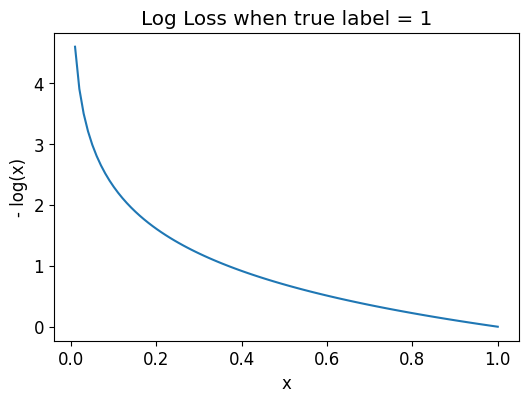

In [30]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [31]:
from IPython.display import HTML
import pandas as pd
# import re

df['loss'] = -torch.log(tensor(df['result']))

t = df.style.hide(axis='index')

# html = t._repr_html_()
# 
# html = re.sub(r'<style.*?</style>', '', html)

display(t)


3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


In [32]:
loss_func = nn.CrossEntropyLoss() #  does log_softmax and then nll_loss

In [33]:
loss_func(acts, targ)

tensor(1.8045)

In [34]:
F.cross_entropy(acts, targ) # same as above

tensor(1.8045)

In [35]:
nn.CrossEntropyLoss(reduction='none')(acts, targ) # all the results, without taking mean

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [37]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.155908,0.320190,0.097429,22:42
1,0.535431,0.244082,0.076455,23:16
2,0.345934,0.202625,0.064276,20:32


epoch,train_loss,valid_loss,error_rate,time
0,0.268064,0.202836,0.062246,33:04
1,0.266467,0.189444,0.057510,33:29
2,0.246409,0.187502,0.058187,33:10
3,0.213127,0.184210,0.056834,33:05


KeyboardInterrupt: 